In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
# import utils.mpl_pubstyle  # noqa: F401
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# # Prepare to read multiple result files
testname = 'NvsNt1'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))

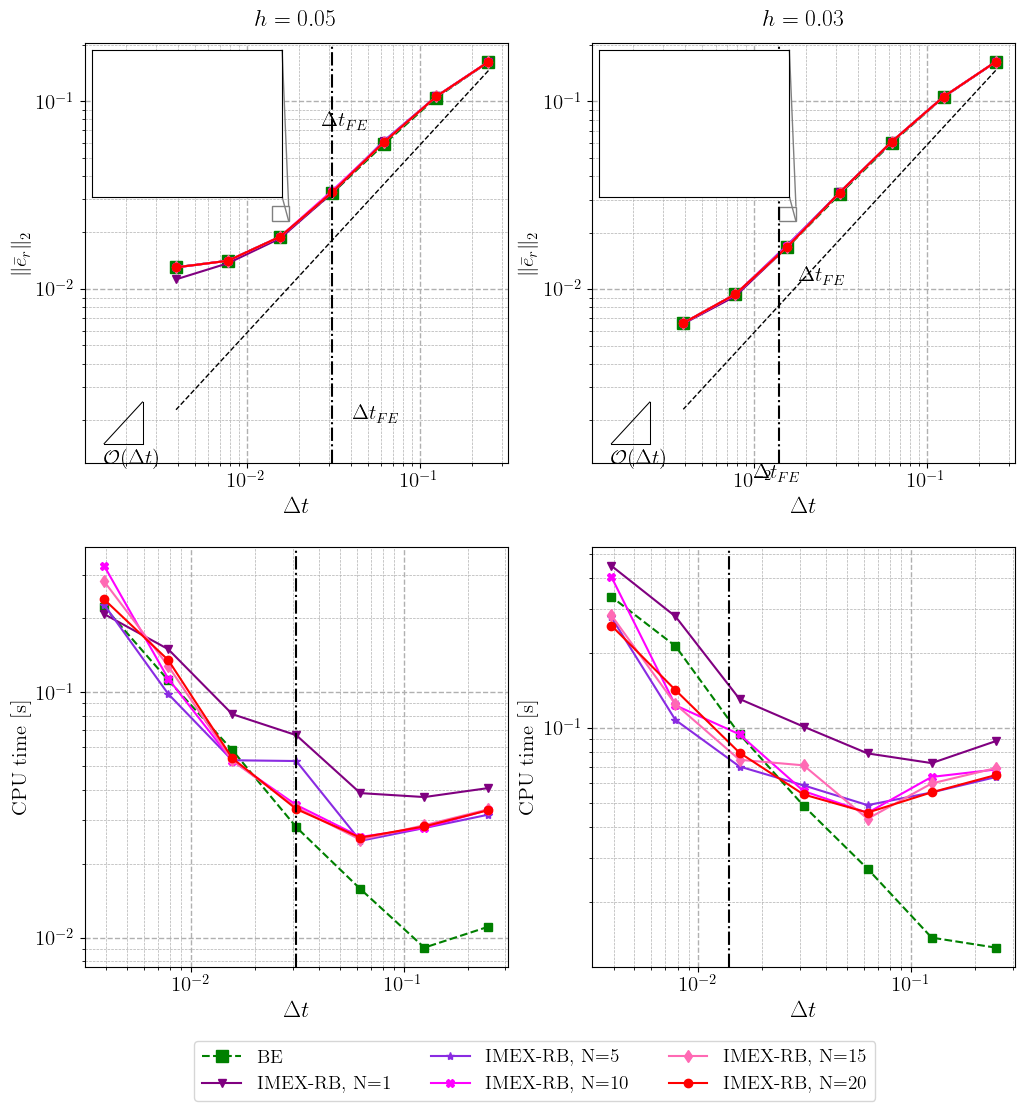

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
problem_name = "AdvDiff2D"
# Load the single results file which now contains data for all Nx_values
results_path = os.path.join(
    base_dir,
    os.pardir,
    os.pardir,
    "__RESULTS",
    problem_name,
    testname,
    "results.npz",
)

all_markers = ["v", "*", "X", "d", "o", "p", "s", "h"]
all_colors = [
    "purple",
    "blueviolet",
    "magenta",
    "hotpink",
    "red",
    "maroon",
    "teal",
    "orange",
]

results = np.load(results_path, allow_pickle=True)
Nx_values = results["Nx_values"]           # array of grid sizes
Ns = results["N_values"]                   # list of RB dimensions
Nts = results["Nt_values"]                 # list of time-step counts
errBE_all = results["errors_l2"].item()["BE"]       # shape: (len(Nts), len(Nx_values))
errIMEX_all = results["errors_l2"].item()["IMEX-RB"]  # shape: (len(Nts), len(Ns), len(Nx_values))
timesBE_all = results["times"].item()["BE"]           # shape: (len(Nts), len(Nx_values))
timesIMEX_all = results["times"].item()["IMEX-RB"]     # shape: (len(Nts), len(Ns), len(Nx_values))
subiters_all = results["subiters"].item()["IMEX-RB"]  # shape: (len(Nts), nIMEX, max_Nt, len(Nx_values))
Nt_FE_all = results["Nt_FE"]                   # array of FE limits

nIMEX = errIMEX_all.shape[1]
all_markers = all_markers[:nIMEX]
all_colors = all_colors[:nIMEX]

xdeltaFE = [1 / Nt_FE * 1.3 for Nt_FE in Nt_FE_all for _ in range(2)]
ydeltaFE = [2e-3, 2e1, 1.1e-2, 1e0]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for col, Nh in enumerate(Nx_values):
    pos = axs[0, col].get_position()
    x = pos.x0 + pos.width / 2
    y = pos.y1 + 0.01
    fig.text(
        x,
        y,
        rf"$h = {1/Nh:.2f}$",
        ha="center",
        va="bottom",
        fontsize=17,
    )

    errBE = errBE_all[:, col]
    errIMEX = errIMEX_all[:, :, col]
    timesBE = timesBE_all[:, col]
    timesIMEX = timesIMEX_all[:, :, col]
    Nt_FE = Nt_FE_all[col]

    ax_err = axs[0, col]
    ax_err.loglog(
        1 / Nts,
        errBE,
        "--s",
        markersize=8,
        color="green",
        label="BE",
    )
    for i in range(nIMEX):
        ax_err.loglog(
            1 / Nts,
            errIMEX[:, i],
            f"-{all_markers[i]}",
            markersize=6,
            color=all_colors[i],
            label=f"IMEX-RB, N={Ns[i]}",
        )
    ax_err.loglog(
        1 / Nts,
        (Nts[0] * errBE[0] * 0.9) / Nts,
        color="k",
        linestyle="--",
        linewidth=1,
    )

    x0, y0 = 0.0015, 0.0015
    dx = 0.001
    dy = dx
    ax_err.plot([x0, x0 + dx], [y0, y0], "k-", linewidth=0.75)
    ax_err.plot(
        [x0 + dx, x0 + dx], [y0, y0 + dy], "k-", linewidth=0.75
    )
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], "k-", linewidth=0.75)
    ax_err.text(
        x0,
        y0 - dy / 2.5,
        r"$\mathcal{O}(\Delta t)$",
        fontsize=15,
        ha="left",
        va="bottom",
    )
    ax_err.axvline(1 / Nt_FE, color="k", linestyle="-.")

    ax_err.text(
        xdeltaFE[2 * col],
        ydeltaFE[2 * col],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color="k",
    )

    axins = inset_axes(ax_err, width="45%", height="35%", loc="upper left")
    axins.loglog(
        1 / Nts,
        errBE,
        "--s",
        markersize=8,
        color="green",
    )
    for i in range(nIMEX):
        axins.loglog(
            1 / Nts,
            errIMEX[:, i],
            f"-{all_markers[i]}",
            markersize=6,
            color=all_colors[i],
        )
    axins.set_xlim(1.4e-2, 1.75e-2)
    axins.set_ylim(2.3e-2, 2.75e-2)
    axins.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False,
    )
    mark_inset(ax_err, axins, loc1=1, loc2=4, fc="none", ec="0.5")

    ax_err.grid(which="major", linewidth=1, linestyle="--")
    ax_err.grid(which="minor", linewidth=0.5, linestyle="--")
    ax_err.tick_params(axis="both", which="major", labelsize=15)
    ax_err.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_err.set_ylabel(r"$\|\bar{e}_r\|_2$", fontsize=15)

    ax_time = axs[1, col]
    ax_time.loglog(
        1 / Nts,
        timesBE,
        "--s",
        markersize=6,
        color="green",
        label="BE",
    )
    for i in range(nIMEX):
        ax_time.loglog(
            1 / Nts,
            timesIMEX[:, i],
            f"-{all_markers[i]}",
            markersize=6,
            color=all_colors[i],
            label=f"IMEX-RB, N={Ns[i]}",
        )
    ax_time.axvline(1 / Nt_FE, color="k", linestyle="-.")

    ax_time.text(
        xdeltaFE[2 * col + 1],
        ydeltaFE[2 * col + 1],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color="k",
    )
    ax_time.grid(which="major", linestyle="--", linewidth=1)
    ax_time.grid(which="minor", linestyle="--", linewidth=0.5)
    ax_time.tick_params(axis="both", which="major", labelsize=15)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_time.set_ylabel("CPU time [s]", fontsize=15)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.01),
    ncol=3,
    fontsize=14,
)

plt.savefig(
    os.path.join(
        "plots", f"{problem_name}_convergence_times_N.pdf"
    ),
    bbox_inches="tight",
)


### Process subiterations for a given space discretization
Look at average inner iterations varying $\Delta t$ and iterations over time
for one $\Delta t$

In [4]:
# Read now a single result file, i.e. a single Nx
idx_Nx = 1
# Extract data for this grid size
errBE = errBE_all[:, col]
errIMEX = errIMEX_all[:, :, col]
timesBE = timesBE_all[:, col]
timesIMEX = timesIMEX_all[:, :, col]
Nt_FE = Nt_FE_all[col]
subiters = subiters_all[:, :, :, col]
# Masking sub-iterations
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

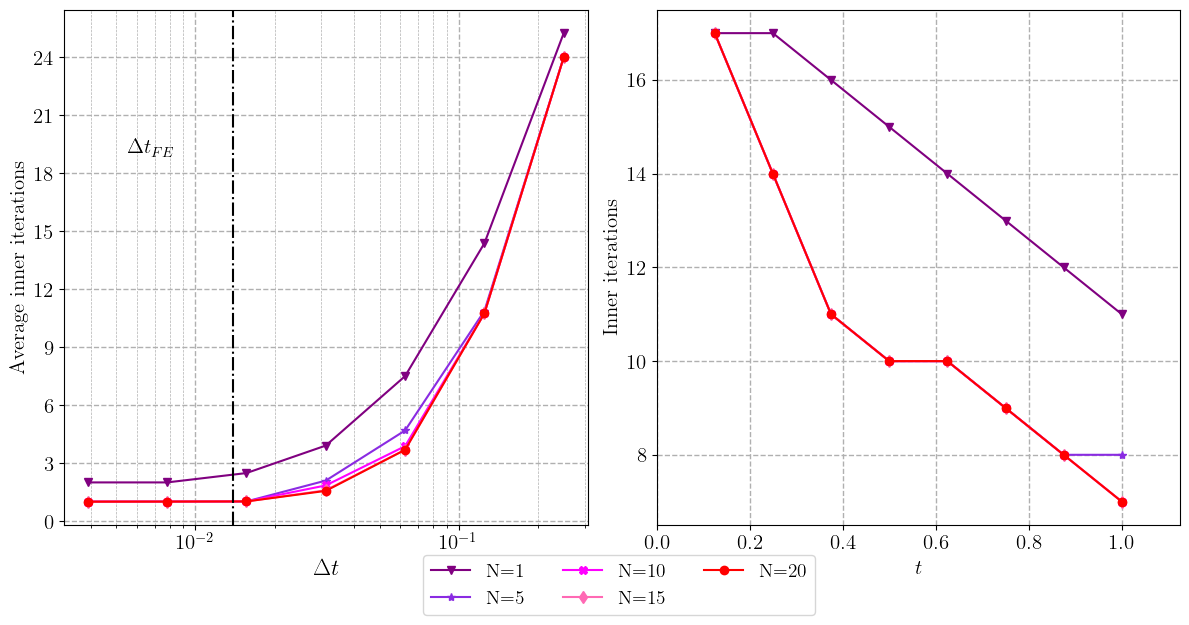

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: average inner iterations
ax = axs[0]
for i, (m, c) in enumerate(zip(all_markers, all_colors)):
    mean_iter = np.mean(masked_subiters[:, i] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
ax.text(5.5e-3, 19, r"$\Delta t_{FE}$", fontsize=15, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.grid(axis='x', which='minor', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Average inner iterations", fontsize=15)

# Right subplot: inner iterations vs time
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for i, (m, c) in enumerate(zip(all_markers, all_colors)):
    ax.plot(
        tvec,
        subiters[Nt_idx, i, :Nts[Nt_idx]] + 1,
        f'-{m}',  # use the same marker as in the left plot
        markersize=6,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel("Inner iterations", fontsize=15)

# external legend on the right, one column (using legend from the left subplot)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.52, -0.05),
    fontsize=14,
    ncol=3
)
plt.tight_layout()
plt.savefig('plots/' + f'{problem_name}_' + f'iters_N_Nx_{Nx_values[idx_Nx]}.pdf', bbox_inches="tight")
